In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
from fastshap import KernelExplainer



/trinity/home/atheodosiadou/miniconda3/envs/macro_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
path = '/trinity/home/atheodosiadou/macro/raw_data/ChIP_comb/ChIP_comb_merged_per_donor/bed_intersect/EGR2_H3K27ac_LPS/EGR2_H3K27ac_LPS_ctrl_overlap_modified_008.bed'
data = pd.read_csv(path, sep="\t", header=None)

feature_names = ["chr_h3k", "start_h3k", "end_h3k", "mvalue_h3k", "avalue_h3k", "pvalue_h3k", "peak_group_h3k",
                 "normalized_density_1_h3k", "normalized_density_2_h3k", 
                 "chr_tf", "start_tf", "end_tf", "mvalue_tf","avalue_tf", "pvalue_tf", "peak_group_tf",
                 "normalized_density_1_tf", "normalized_density_2_tf",
                 "annotation_gene", "distance_to_TSS", "symbol", "gene_name", "overlap"]
data.columns = feature_names

fibrosis_genes_df = pd.read_csv('/trinity/home/atheodosiadou/macro/raw_data/fibrosis/uniprotkb_fibrosis_AND_model_organism_9_2025_06_19.tsv', sep="\t", header = 0)
fibrosis_genes = fibrosis_genes_df['Gene Names'].str.split().explode().unique()
print(fibrosis_genes)
data['fibrosis'] = data['symbol'].isin(fibrosis_genes).astype(int)
print(data)
print(data['fibrosis'].value_counts())

['IFT56' 'TTC26' 'NBAS' 'NAG' 'TMEM218' 'CLCA1' 'CACC1' 'DNASE2' 'DNASE2A'
 'DNL2' 'AP3B1' 'ADTB3A' 'PSMD11' 'PSMD12' 'PLOD2' 'PSMD14' 'POH1' 'AP3D1'
 'PRO0039' 'NHERF1' 'NHERF' 'SLC9A3R1' 'TERT' 'EST2' 'TCS1' 'TRT' 'PHOX2A'
 'ARIX' 'PMX2A' 'PSMA7' 'HSPC' 'NPHP1' 'NPH1' 'KCNN4' 'IK1' 'IKCA1' 'KCA4'
 'SK4' 'PSMD3' 'ATP8B1' 'ATPIC' 'FIC1' 'PFIC' 'SPRY2' 'SPRY3' 'PDE6D'
 'PDED' 'KATNIP' 'KIAA0556' 'CEP104' 'KIAA0562' 'MAPKBP1' 'JNKBP1'
 'KIAA0596' 'TLR5' 'TIL3' 'RAMP3' 'NPHP4' 'KIAA0673' 'SEMA7A' 'CD108'
 'SEMAL' 'TULP3' 'TUBL3' 'ERLIN1' 'C10orf69' 'KE04' 'KEO4' 'SPFH1'
 'ERLIN2' 'C8orf2' 'SPFH2' 'UNQ2441/PRO5003/PRO9924' 'ABCB11' 'BSEP'
 'PARN' 'DAN' 'MPIG6B' 'C6orf25' 'G6B' 'G6B-B' 'AGR2' 'AG2'
 'UNQ515/PRO1030' 'REN' 'MT-ATP6' 'ATP6' 'ATPASE6' 'MTATP6' 'SERPINA1'
 'AAT' 'PI' 'PRO0684' 'PRO2209' 'C5' 'CPAMD4' 'TGFB1' 'TGFB' 'PF4' 'CXCL4'
 'SCYB4' 'MT-ATP8' 'ATP8' 'ATPASE8' 'MTATP8' 'TYMS' 'TS' 'OK/SW-cl.29'
 'S100A8' 'CAGA' 'CFAG' 'MRP8' 'KRT18' 'CYK18' 'PIG46' 'KRT8' 'CYK8'
 'S100A9' '

In [3]:
# Chromosome conversion

def extract_chromosome_number(chrom):
    try:
        return int(chrom[3:])
    except ValueError:
        return {'X': 23, 'Y': 24}.get(chrom[3:], np.nan)

data["chr_h3k"] = data["chr_h3k"].apply(extract_chromosome_number)
data["chr_tf"] = data["chr_tf"].apply(extract_chromosome_number)

# Label mappings
tf_mapping = {'EGR2_LPS.macs3_peaks_filtered_unique': 0, 'EGR2_ctrl.macs3_peaks_filtered_unique': 1, 'merged_common': 2}
h3k_mapping = {'H3K27ac_LPS.macs3.broad_peaks_filtered_unique': 0, 'H3K27ac_ctrl.macs3.broad_peaks_filtered_unique': 1, 'merged_common' : 2, '.': -1}

def annotation_encoder(val):
    if pd.isna(val) or val == ".": return -1
    val = val.lower()
    return {
        "promoter_(<=1kb)": 0, "promoter_(1-2kb)": 1, "promoter_(2-3kb)": 2,
        "intron": 3, "exon": 4, "5'utr": 5, "3'utr": 6,
        "distal_intergenic": 7, "downstream": 8
    }.get(val, -1)

# Feature prep
X = data.drop(["mvalue_h3k", "avalue_h3k", "pvalue_h3k", "normalized_density_1_h3k", "normalized_density_2_h3k",
               "chr_tf", "start_tf", "end_tf", "avalue_tf", "pvalue_tf", "normalized_density_1_tf", "normalized_density_2_tf",
               "distance_to_TSS", "symbol", "gene_name"], axis=1)
X['peak_group_h3k'] = X['peak_group_h3k'].map(h3k_mapping)
X['peak_group_tf'] = X['peak_group_tf'].map(tf_mapping)
X['annotation_gene'] = X['annotation_gene'].apply(annotation_encoder)
X['overlap'] = X['overlap'].apply(lambda x: 1 if int(x) > 0 else 0)
y = data["mvalue_h3k"]
print(data)

       chr_h3k  start_h3k   end_h3k  mvalue_h3k  avalue_h3k  pvalue_h3k  \
0            1      29013     29429           1     3.49150    0.068192   
1            1      96433     96816           2     3.60837    0.002205   
2            1     103955    104376           2     3.47710    0.004901   
3            1     778202    779102           1     5.09615    0.026789   
4            1     817205    817644           1     4.75711    0.014867   
...        ...        ...       ...         ...         ...         ...   
63029       22   50620434  50620723           1     3.83089    0.063203   
63030       22   50627941  50628525           1     4.20097    0.064293   
63031       22   50656290  50656640           2     3.27537    0.012938   
63032       22   50756917  50757302           1     3.76080    0.064760   
63033       22   50783397  50783958           1     4.42860    0.040041   

                            peak_group_h3k  normalized_density_1_h3k  \
0                          

In [4]:
# #keep only the 2 minority classes(mvalue_h3k == 1 and mvalue_h3k == -1)
# data = data[(data['mvalue_h3k'] == 1) | (data['mvalue_h3k'] == -1)]

In [5]:
# Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
# Identify columns with "." and replace with NaN
for col in X.columns:
    try:
        X_train[col] = pd.to_numeric(X_train[col])  # Try to convert to numeric
        X_test[col] = pd.to_numeric(X_test[col])
    except ValueError:
        print(f"Column {col} contains non-numeric values. Replacing '.' with NaN.")
        X_train[col] = X_train[col].replace('.', np.nan)  # Replace "." with NaN
        X_test[col] = X_test[col].replace('.', np.nan)
        X_train[col] = pd.to_numeric(X_train[col])  # Convert to numeric after replacement
        X_test[col] = pd.to_numeric(X_test[col])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

Column mvalue_tf contains non-numeric values. Replacing '.' with NaN.


In [7]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [8]:
# Dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy_scores = cross_val_score(dummy, X_train, y_train, cv=skf, scoring='f1_weighted')
print("\nBaseline Dummy Classifier F1 (Weighted) CV Scores:", dummy_scores)
print("Mean F1:", np.mean(dummy_scores))


Baseline Dummy Classifier F1 (Weighted) CV Scores: [0.39060392 0.39060392 0.3906734 ]
Mean F1: 0.3906270788786059


In [9]:
# Random Forest with SMOTE pipeline
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
param_grid_rf = {
    'clf__n_estimators': [500, 1000],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth': [None, 10, 20],
    'clf__criterion': ['gini', 'entropy']
}
rf_search = RandomizedSearchCV(rf_pipeline, param_grid_rf, n_iter=5, scoring='f1_weighted', n_jobs=-1, cv=skf)
rf_search.fit(X_train, y_train)
print("\nBest RF params:", rf_search.best_params_)
y_pred_rf = rf_search.best_estimator_.predict(X_test)
print("\nRandom Forest Classification Report:")
report = classification_report(y_test, y_pred_rf)
print(report)

# Save to a text file
with open("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/classification_report_rf_272_manorm_008.txt", "w") as f:
    f.write(report)



# ])
# param_grid = {
#     'clf__n_estimators': [500, 1000],
#     'clf__max_features': ['sqrt', 'log2'],
#     'clf__max_depth': [None, 10, 20],
#     'clf__criterion': ['gini', 'entropy'],
#     'clf__min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(rf_pipeline, param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1)
# grid.fit(X_train, y_train)
# print("\nBest RF params:", grid.best_params_)
# y_pred_rf = grid.best_estimator_.predict(X_test)
# print("\nRandom Forest Classification Report:")
# print(classification_report(y_test, y_pred_rf))


Best RF params: {'clf__n_estimators': 500, 'clf__max_features': 'log2', 'clf__max_depth': 20, 'clf__criterion': 'entropy'}

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.42      0.44      1223
           1       0.75      0.71      0.73      6937
           2       0.68      0.75      0.71      4447

    accuracy                           0.70     12607
   macro avg       0.63      0.63      0.63     12607
weighted avg       0.70      0.70      0.69     12607



In [10]:
# Logistic Regression pipeline
lr_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, class_weight='balanced', random_state=42))
])

# Logistic Regression hyperparameter tuning
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1]
}

lr_search = RandomizedSearchCV(lr_pipeline, param_grid_lr, n_iter=3, scoring='f1_weighted', n_jobs=-1, cv=skf)
lr_search.fit(X_train, y_train)
print("\nBest LR params:", lr_search.best_params_)
y_pred_lr = lr_search.best_estimator_.predict(X_test)

print("\nLogistic Regression Report:")


report = classification_report(y_test, y_pred_lr, zero_division=0)
print(report)

# Save to a text file
with open("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/classification_report_lr_272_manorm_008.txt", "w") as f:
    f.write(report)


Best LR params: {'clf__C': 0.1}

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1223
           1       0.55      0.19      0.28      6937
           2       0.35      0.80      0.48      4447

    accuracy                           0.39     12607
   macro avg       0.30      0.33      0.26     12607
weighted avg       0.42      0.39      0.33     12607



In [11]:
# XGBoost pipeline
xgb_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# XGBoost hyperparameter tuning
param_grid_xgb = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__gamma': [0, 0.1, 0.2]
}

xgb_search = RandomizedSearchCV(xgb_pipeline, param_grid_xgb,  n_iter=5, scoring='f1_weighted', n_jobs=-1, cv=skf)
xgb_search.fit(X_train, y_train)
print("\nBest XGB params:", xgb_search.best_params_)
y_pred_xgb = xgb_search.best_estimator_.predict(X_test)

report = classification_report(y_test, y_pred_xgb)
print(report)

# Save to a text file
with open("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/classification_report_xgb_272_manorm_008.txt", "w") as f:
    f.write(report)


Best XGB params: {'clf__n_estimators': 500, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__gamma': 0}
              precision    recall  f1-score   support

           0       0.43      0.33      0.37      1223
           1       0.74      0.70      0.72      6937
           2       0.65      0.75      0.70      4447

    accuracy                           0.68     12607
   macro avg       0.61      0.59      0.60     12607
weighted avg       0.68      0.68      0.68     12607



In [12]:
# # SVM pipeline
# svm_pipeline = ImbPipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('clf', SVC(kernel='linear', class_weight='balanced', probability=False, random_state=42))
# ])

# # # SVM hyperparameter tuning
# # param_grid_svm = {
# #     'clf__C': [0.1, 1, 10],
# #     'clf__gamma': [0.001, 0.01, 0.1]
# # }
# # svm_search = RandomizedSearchCV(svm_pipeline, param_grid_svm, n_iter=5, scoring='f1_weighted', n_jobs=-1, cv=skf)
# # svm_search.fit(X_train, y_train)
# # print("\nBest SVM params:", svm_search.best_params_)

# # y_pred_svm = svm_search.best_estimator_.predict(X_test)


# # svm_pipeline.fit(X_train, y_train)
# # print("\nBest SVM params:", svm_pipeline.best_params_)

# # y_pred_svm = svm_pipeline.best_estimator_.predict(X_test)


# # svm_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=skf, scoring='f1_weighted')
# # print("\nSVM CV F1 Scores:", svm_scores)
# svm_pipeline.fit(X_train, y_train)
# y_pred_svm = svm_pipeline.predict(X_test)
# print("\nSVM Report:")

# report = classification_report(y_test, y_pred_svm, zero_division=0) #  Handle zero division
# print(report)

# # Save to a text file
# with open("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/classification_report_svm_272_manorm_008.txt", "w") as f:
#     f.write(report)

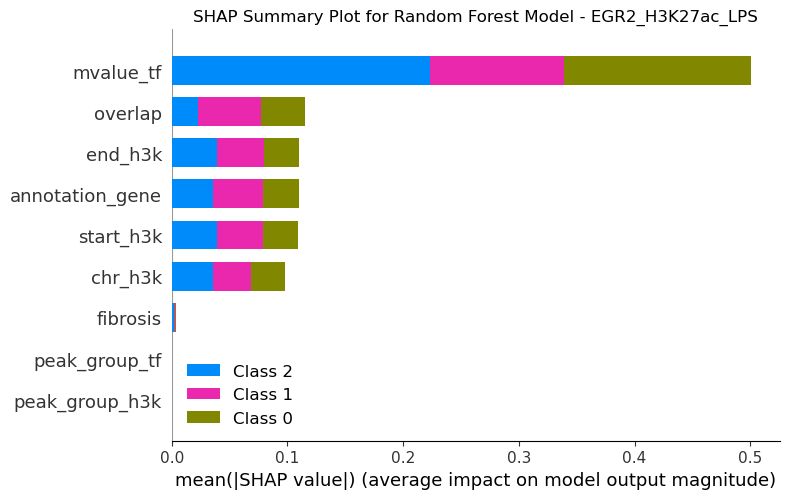

In [13]:
# SHAP values for best RF
sample_X = shap.sample(pd.DataFrame(X_test, columns=X.columns), 100, random_state=42)
explainer = shap.TreeExplainer(rf_search.best_estimator_.named_steps['clf'])
shap_values = explainer(sample_X)
shap.summary_plot(shap_values, features=sample_X, feature_names=[sample_X.columns[i] for i in range(sample_X.shape[1])], show=False)
plt.title("SHAP Summary Plot for Random Forest Model - EGR2_H3K27ac_LPS")
plt.tight_layout()
plt.savefig("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/shap_summary_272_manorm_008.png", dpi=150)
plt.show()

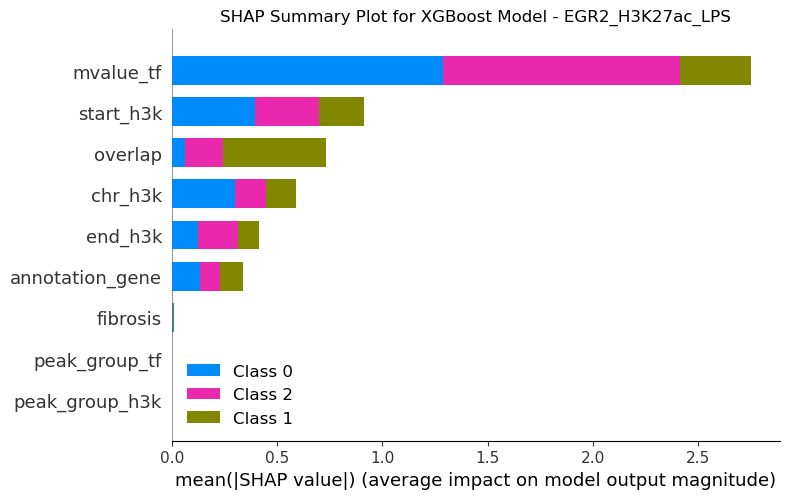

In [14]:
# SHAP values for best XGB
sample_X = shap.sample(pd.DataFrame(X_test, columns=X.columns), 100, random_state=42)
explainer = shap.Explainer(xgb_search.best_estimator_.named_steps['clf'])
shap_values = explainer(sample_X)
shap.summary_plot(shap_values, features=sample_X, feature_names=[sample_X.columns[i] for i in range(sample_X.shape[1])], show=False)
plt.title("SHAP Summary Plot for XGBoost Model - EGR2_H3K27ac_LPS")
plt.tight_layout()
plt.savefig("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/shap_summary_xgb_272_manorm_008.png", dpi=150)
plt.show()

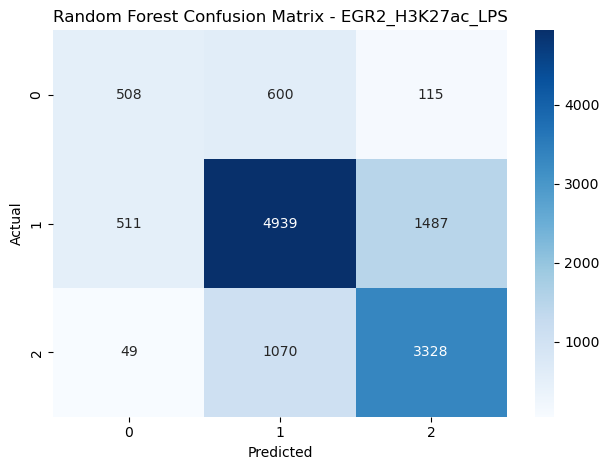

In [15]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix - EGR2_H3K27ac_LPS")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/confusion_matrix_rf_272_manorm_008.png")
plt.show()

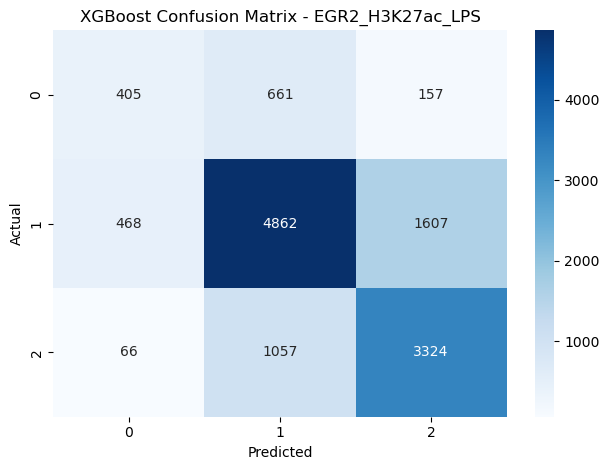

In [16]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix - EGR2_H3K27ac_LPS")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/confusion_matrix_xgb_272_manorm_008.png")
plt.show()

In [17]:
# --- Append this block at the end of your script ---

# == Analyzing most important peaks for mvalue = 1 and overlap = 1 ==

# Recreate column names from X after preprocessing
column_names = X.columns.tolist()
print(column_names)

# Convert X_test back to DataFrame
X_test_df = pd.DataFrame(X_test, columns=column_names)
# print(X_test_df.head())
X_test_df = X_test_df.reset_index(drop=True)
# print(X_test_df)
y_test_reset = y_test.reset_index(drop=True)
# print(y_test_reset)


# Merge with original test rows for context
original_test_data = data.iloc[y_test.index].reset_index(drop=True) #this will keep the original rows intact and the original column names
# print(original_test_data.head())

# Filter for rows where mvalue == 1 and overlap == 1
filtered_idx = (y_test_reset == 2) & (X_test_df['overlap'] == 1) #false for the cases where mvalue == 0 or 1, and true for the cases where mvalue == 2
# print(filtered_idx)
X_filtered = X_test_df[filtered_idx]
# print(X_filtered)
original_filtered = original_test_data[filtered_idx].copy() #uses the same rows as X_filtered but keeps the original columns
# print(original_filtered)

# SHAP explainer from RF already defined: 'explainer'
# Compute SHAP values on filtered rows
print("\nComputing SHAP values for mvalue=2 and overlap=1 subset...")

shap_values_filtered = explainer(X_filtered)
# print(shap_values_filtered)
shap_vals_array = shap_values_filtered.values
# print(shap_vals_array)
print(f"SHAP values shape: {shap_vals_array.shape}")

# Compute mean absolute SHAP values across filtered samples
mean_abs_shap = np.abs(shap_vals_array[:, :, 2]).mean(axis=0)
print(mean_abs_shap)  
shap_feature_importance = pd.DataFrame({
    'Feature': column_names,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values(by='Mean_Abs_SHAP', ascending=False)

# Output top features
print("\nTop features contributing to mvalue = 2 and overlap = 1:")
print(shap_feature_importance.head(10))

# Sample-level total contribution
shap_total_contrib = np.sum(np.abs(shap_vals_array[:, :, 2]), axis=1)
print(f"Total SHAP contributions shape: {shap_total_contrib.shape}")
print(f"Total SHAP contributions: {shap_total_contrib}")
original_filtered['Total_SHAP'] = shap_total_contrib

# Sort and show top peaks
top_peaks = original_filtered.sort_values(by='Total_SHAP', ascending=False).head(10)
print("\nTop peaks contributing to mvalue = 2 and overlap = 1:")
print(top_peaks[['chr_h3k', 'start_h3k', 'end_h3k', 'symbol', 'annotation_gene','fibrosis', 'Total_SHAP']])

# Save to CSV
top_peaks.to_csv("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/fibrosis/EGR2_H3K27ac_LPS/top_peaks_mval1_overlap1_272_manorm_008.csv", sep="\t",  index=False)

['chr_h3k', 'start_h3k', 'end_h3k', 'peak_group_h3k', 'mvalue_tf', 'peak_group_tf', 'annotation_gene', 'overlap', 'fibrosis']

Computing SHAP values for mvalue=2 and overlap=1 subset...
SHAP values shape: (2559, 9, 3)
[0.1319384  0.2707882  0.14696974 0.         1.0073357  0.
 0.10899493 0.15693966 0.00318313]

Top features contributing to mvalue = 2 and overlap = 1:
           Feature  Mean_Abs_SHAP
4        mvalue_tf       1.007336
1        start_h3k       0.270788
7          overlap       0.156940
2          end_h3k       0.146970
0          chr_h3k       0.131938
6  annotation_gene       0.108995
8         fibrosis       0.003183
3   peak_group_h3k       0.000000
5    peak_group_tf       0.000000
Total SHAP contributions shape: (2559,)
Total SHAP contributions: [2.5732567 1.6696671 2.7345917 ... 1.8291842 2.0298696 2.5806925]

Top peaks contributing to mvalue = 2 and overlap = 1:
       chr_h3k  start_h3k    end_h3k     symbol  \
1654         2  231250683  231250988      ARMC9   
1

In [18]:
# # 4. Feature Selection using Permutation Importance
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# print(f"After SMOTE, X_train shape: {X_train_smote.shape}, y_train shape: {y_train_smote.shape}")
# y_train_smote.hist()
# model_for_feature_selection = RandomForestClassifier(n_estimators=1000, random_state=42)
# model_for_feature_selection.fit(X_train_smote, y_train_smote)

# # Select features based on importance
# sfm = SelectFromModel(model_for_feature_selection, threshold=0.0001)  
# sfm.fit(X_train_smote, y_train_smote)
# X_train_selected = sfm.transform(X_train_smote)
# X_test_selected = sfm.transform(X_test)

# # Get selected feature names
# selected_feature_indices = sfm.get_support(indices=True)
# selected_feature_names = [X.columns[i] for i in selected_feature_indices]


In [19]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [500,1000],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],
#     # 'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     # 'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy'],
#     # 'max_samples': [None, 0.5, 0.75],  # Optional, for sub-sampling
#     # 'max_leaf_nodes': [None, 10, 20, 30],  # Optional, for limiting leaf nodes
#     # 'min_weight_fraction_leaf': [0.1, 0.2],  # Optional, for handling class imbalance
#     # 'ccp_alpha': [0.0, 0.01, 0.1],  # Optional, for pruning
#     # 'class_weight': ['balanced', 'balanced_subsample']  # Optional, for handling class imbalance
# }

# # GridSearchCV
# rf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
# grid_search.fit(X_train_selected, y_train_smote)  # Use balanced y after SMOTE

# print("Best parameters found:", grid_search.best_params_)
# print("Best cross-validated F1 score:", grid_search.best_score_)

# # Use the best estimator for further analysis
# model = grid_search.best_estimator_


In [20]:
# # 6. Model Evaluation
# y_pred = model.predict(X_test_selected)
# balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
# print(f"Balanced Accuracy: {balanced_accuracy}")
# # accuracy = accuracy_score(y_test, y_pred)
# # print(f"Accuracy: {accuracy}")
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.savefig("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/per_donor/EGR2_H3K27ac_LPS/confusion_matrix_minority_no_start_end.png")
# plt.show()

In [21]:
# # 7. Feature Importance Plot (using selected features)
# result = permutation_importance(model, X_test_selected, y_test, n_repeats=10, random_state=42)
# importances = result.importances_mean
# indices = np.argsort(importances)[::-1]
# print(indices)
# print("Selected feature names:", selected_feature_names)
# print("Feature importances (selected features):")

# plt.figure(figsize=(12, 10))
# plt.title("Feature Importances (Selected Features)")
# plt.bar(range(X_train_selected.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train_selected.shape[1]), [selected_feature_names[i] for i in indices], rotation=90)
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.tight_layout()
# plt.savefig("/trinity/home/atheodosiadou/macro/results/ChIP_comb/models/per_donor/per_donor/EGR2_H3K27ac_LPS/feature_importances_selected_0001_minority.png")
# plt.show()